In [ ]:
import numpy as np
import random as r
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import statistics

In [ ]:
def get_Q(I,M,L,lead_time):
  if I < L and 0<= lead_time <= 1:
    QU = M-I
  elif lead_time ==20 and I < L:
    QU = M-I
  else:
    QU = 0
  return QU 

In [ ]:
def order_cost(Q):
  if Q > 0:
   return 60 + 5*Q
  else:
    return 0

In [ ]:
def back_cost(I):
  if I < 0:
    return -I*4
  else:
    return 0 

In [ ]:
def inv_cost(I):
  if I > 0:
    return I
  else:
    return 0

In [ ]:
def selling(inv,monthly_demand,order_reciept,start_inv):
  b = start_inv
  m = inv
  revenue = []
  for i in range(1):
    if order_reciept[i]+b[i] > 0:
      sales = min(order_reciept[i]+b[i],monthly_demand[i])*10
      revenue.append(sales)

  for i in range(1,len(inv),1):
    z = m[i-1] 
    if z > 0 :
      sales = min(z,monthly_demand[i])*5
      if monthly_demand[i] > z:
        sales = sales+ 10*min(b[i]-z,monthly_demand[i]-z)
    elif b[i] > 0:
      if m[i-1] >= 0:
        sales = min(b[i],monthly_demand[i])*10
      else:
        sales = min(order_reciept[i],monthly_demand[i]-m[i-1])*10
    else:
      sales = 0
    revenue.append(sales)
  return revenue

In [ ]:
def simulation(no_of_replication = 1, length_of_each_run = 120, warm_up = 20, S = 50 ,s = 30 , backorder = True ):
  L = length_of_each_run
  n = no_of_replication
  warm_up_period = warm_up
  mean_profit = []
  mean_monthly_cost = []
  csl = [] #service level
  data = pd.DataFrame(data = None)
  for i in range(n):
    z = -1
    order_reciept = int(L+2)*[0] # creating this for assigning order quantity recival to particular month because suppose if lead time is more than 1 month then adding order quantity in second month
    I = S #initial inventory
    monthly_cost = []
    monthly_orders = []
    monthly_demand = []
    start_inv = []
    t = 0 #initial month
    L_time = 20
    inv = []
    lead = []
    while t < L: # run for L month
      I = I + order_reciept[t] # assigned order quantity if lead time is more than 1 month 
      start_inv.append(I)
      d_t = 0 # initialize demand time in given month
      dm = [] 
      while d_t < 1: # writing code to evaluate total demand occured in a given month
        d_t = d_t + r.expovariate(15)
        pr = r.uniform(0,1)
        if pr >= 0 and pr<= 0.5:
          D = 1
        elif 0.5 < pr <= 0.75:
          D = 2
        elif 0.75 < pr <= 7/8:  
          D = 3
        else:
          D = 4
        dm.append(D)
      demand = sum(dm) # this will give total demand of that month
      monthly_demand.append(demand)

      I = I -demand

      if t >= 1:
        z = inv[t-1]   - monthly_demand[t]
      if z > 0:
        I = I - z
      ###
      if backorder == False:
        if I < 0:
          I = 0
      ###
      Q = get_Q(I,S,s,L_time)
      monthly_cost.append(order_cost(Q)+back_cost(I)+ inv_cost(I))
      inv.append(I)
      monthly_orders.append(Q)
      if Q > 0:
        L_time = r.uniform(0.25,1.25)
      else:
        L_time = 0
      lead.append(L_time)
      if 0.25 <= L_time <= 1 and Q > 0: #if lead time is less than 1 month that means we are getting our ordered quantity in next month
        order_reciept[t+1] = Q
      elif L_time > 1 and Q > 0: # therefore in next month inventory becomes on hand inventory plus recieved quanity
        order_reciept[t+2] = Q
        order_reciept[t+1] = 0
      t = t + 1 
    #print('inv',inv)
    #print('demand',monthly_demand)
    #print('order_reciept',order_reciept)
    #print('leadtime',lead) 
    #print('monthlycost',monthly_cost)
    seling = selling(inv,monthly_demand,order_reciept,start_inv)
    modified_inv = [S,*inv]
    ser_level_list = []
    sl_count = 0
    for i in range(len(monthly_demand)):
      ser_level_list.append(modified_inv[i] + order_reciept[i] - monthly_demand[i])
    for service_level in ser_level_list[int(warm_up_period):]:
      if service_level >= 0:
        sl_count += 1
    csl.append(sl_count/(len(ser_level_list[int(warm_up_period):])))
    #adjusting for warm up
    monthly_cost = monthly_cost[int(warm_up_period):]
    order_reciept = order_reciept[int(warm_up_period):]
    inv = inv[int(warm_up_period):]
    start_inv = start_inv[int(warm_up_period):]
    seling = seling[int(warm_up_period):]
    monthly_demand = monthly_demand[int(warm_up_period):]

    mean_profit.append(-np.mean(monthly_cost)+ np.mean(seling)) 
    mean_monthly_cost.append(np.mean(monthly_cost))
    #data['START INVENTORY'] = start_inv[:10]
    data['MONTHLY DEMAND'] = monthly_demand[:10]
    data['ORDER RECEIPT'] = order_reciept[:10]
    data['END INVENTORY'] = inv[:10]
    data['MONTHLY ORDER'] = monthly_orders[:10]
    data['MONTHLY COST'] = monthly_cost[:10]
    data['MONTHLY SELLING'] = seling[:10]

 
  return mean_profit,mean_monthly_cost,csl ,data

In [ ]:
#funtion to calculate main effect of a factor given 3 factors and 2 level for each
def main_effect(list, factor):
  assert len(list)== 8
  assert factor == 1 or factor == 2 or factor == 3
  if factor == 1:
    e = ( -1*sum(list[i] for i in range(4)) +1*sum(list[i] for i in range(4,8)))/4
  if factor == 2:
    e = (-list[0] - list[1] + list[2] + list[3] - list[4] - list[5] + list[6] + list[7])/4
  if factor == 3:
    e = (-list[0] + list[1] - list[2] + list[3] - list[4] + list[5] - list[6] + list[7])/4
  
  return e

In [ ]:
#function to calculate interation effect of 2 factors given 3 factors and 2 level for each 
def interation_effect(list, factor1, factor2):
  assert len(list)== 8
  assert factor1 == 1 or factor1 == 2 or factor1 == 3
  assert factor2 == 1 or factor2 == 2 or factor2 == 3
  assert factor1 < factor2
  if factor1 == 1:
    if factor2 == 2:
      e = (list[0] + list[1] - list[2] - list[3] - list[4] - list[5] + list[6] + list[7])/4
    if factor2 == 3:
      e = (list[0] - list[1] + list[2] - list[3] - list[4] + list[5] - list[6] + list[7])/4
  if factor1 == 2:
    if factor2 == 3:
      e = (list[0] - list[1] - list[2] + list[3] + list[4] - list[5] - list[6] + list[7])/4
  return e


In [ ]:
def calculate_mean_and_half_width(list,alpha,no_of_replications):
  mean = np.mean(list)
  S = (statistics.variance(list))**0.5  #s.d. of list
  R = no_of_replications
  t = stats.t.ppf(1-alpha,R-1)
  hw = t*S/np.sqrt(R) #half width
  return round(mean,2), round(hw,2)

Function $simulation$ already has fixed factor F1 (inventory policy) to Level1 and F5 (service level measure) to level2.

These settings are required for solving $option B$ of $Topic 2$. Also we have now included warm up in $simulation$ function.

In [ ]:
factor_level_info = np.array([[True, False],
                              [50, 100],
                              [30, 40]])
                              
#first row is for F2 , 2nd for F3 and so on . 1st column is for Level1 and 2nd for Level2

In [ ]:
#this function returns the main and interation effect when checking for all 8 combination
def performance(factor_level_info,alpha,no_of_replication = 1, 
                length_of_each_run = 120, warm_up = 20,
                S = 50,s = 30, backorder = True ):
  profit_replication_matrix = np.zeros(shape = (8,no_of_replication))
  e2 = []
  e3 = []
  e4 = []
  e23 = []
  e24 = []
  e34 = []
  i = 0
  for backorder_ in factor_level_info[0,:]:
    for S_ in factor_level_info[1,:]:
      for s_ in factor_level_info[2,:]:

        #print(s_)
        #print(S_)
        mean_profit,mean_monthly_cost,csl ,data = simulation(no_of_replication=10,
                                                             length_of_each_run = 120,
                                                             warm_up = 20,
                                                             S = S_, s= s_,
                                                             backorder = backorder_)
        profit_replication_matrix[i,:] = mean_profit
        i += 1
  for k in range(np.shape(profit_replication_matrix)[1]):
    e2.append(main_effect(list(profit_replication_matrix[:,k]),1))
    e3.append(main_effect(list(profit_replication_matrix[:,k]),2))
    e4.append(main_effect(list(profit_replication_matrix[:,k]),3))
    e23.append(interation_effect(list(profit_replication_matrix[:,k]),1,2))
    e24.append(interation_effect(list(profit_replication_matrix[:,k]),1,3))
    e34.append(interation_effect(list(profit_replication_matrix[:,k]),2,3))
  #print(np.shape(profit_replication_matrix))

  return e2, e3, e4, e23, e24, e34


In [ ]:
def calculate_confidence_interval_for_effect(e2,e3,e4,e23,e24,e34):
  print('--------Main_Effect--------')
  print('mean of 90%CI for effect of Factor 2 e2 is',calculate_mean_and_half_width(e2,alpha = 0.01,
                                                                                   no_of_replications=len(e2))[0])
  print('half width of 90%CI for effect of Factor 2 e2 is',calculate_mean_and_half_width(e2,alpha = 0.01,
                                                                                   no_of_replications=len(e2))[1])
  print('mean of 90%CI for effect of Factor 3 e3 is',calculate_mean_and_half_width(e3,alpha = 0.01,
                                                                                   no_of_replications=len(e3))[0])
  print('half width of 90%CI for effect of Factor 3 e3 is',calculate_mean_and_half_width(e3,alpha = 0.01,
                                                                                   no_of_replications=len(e3))[1])
  print('mean of 90%CI for effect of Factor 4 e4 is',calculate_mean_and_half_width(e4,alpha = 0.01,
                                                                                   no_of_replications=len(e4))[0])
  print('half width of 90%CI for effect of Factor 4 e4 is',calculate_mean_and_half_width(e4,alpha = 0.01,
                                                                                   no_of_replications=len(e4))[1])
  print('--------Interaction_Effect----------')
  print('mean of 90%CI for effect of Factor 2and3 e23 is',calculate_mean_and_half_width(e23,alpha = 0.01,
                                                                                   no_of_replications=len(e23))[0])
  print('half width of 90%CI for effect of Factor 2and3 e23 is',calculate_mean_and_half_width(e23,alpha = 0.01,
                                                                                   no_of_replications=len(e23))[1])
  print('mean of 90%CI for effect of Factor 2and4 e24 is',calculate_mean_and_half_width(e24,alpha = 0.01,
                                                                                   no_of_replications=len(e24))[0])
  print('half width of 90%CI for effect of Factor 2and4 e24 is',calculate_mean_and_half_width(e24,alpha = 0.01,
                                                                                   no_of_replications=len(e24))[1])
  print('mean of 90%CI for effect of Factor 3and4 e34 is',calculate_mean_and_half_width(e34,alpha = 0.01,
                                                                                   no_of_replications=len(e34))[0])
  print('half width of 90%CI for effect of Factor 3and4 e34 is',calculate_mean_and_half_width(e34,alpha = 0.01,
                                                                                   no_of_replications=len(e34))[1])

#lets run the simulation

Before that lets write down the intuition:
1. F2 | low : Backorder is allowed | high : Backorder not allowed. If backorder is allowed then we can make more profit by satisfying all demand as selling price is greater than carrying cost. So switching from low to high value of F2 will decrease profit.

2. F3 | low : 50 | high : 100.
Switching from low to high value increases the probability of us satisfying the demand ( so low total backordering cost ) but increases the inventory to carry.Also now we need to order more. So it is more likely that profit will reduce because of high ordering cost when F3 is switched from low to high.

3. F4 | low = 30 | high : 40
Switching from low to high value decreases the probability of us satisfying the demand ( so high total backordering cost ) but decreases the inventory to carry.Also now we need to order less.So no clear indication of behaviour of mean_monthly_profit.

In [ ]:
e2, e3, e4, e23, e24, e34 = performance(factor_level_info, 
                                        alpha = 0.01, no_of_replication = 10,
                                        length_of_each_run=120, warm_up=20)
calculate_confidence_interval_for_effect(e2,e3,e4,e23,e24,e34)

--------Main_Effect--------
mean of 90%CI for effect of Factor 2 e2 is -8.18
half width of 90%CI for effect of Factor 2 e2 is 2.5
mean of 90%CI for effect of Factor 3 e3 is -78.6
half width of 90%CI for effect of Factor 3 e3 is 4.57
mean of 90%CI for effect of Factor 4 e4 is -5.0
half width of 90%CI for effect of Factor 4 e4 is 3.09
--------Interaction_Effect----------
mean of 90%CI for effect of Factor 2and3 e23 is -12.16
half width of 90%CI for effect of Factor 2and3 e23 is 5.26
mean of 90%CI for effect of Factor 2and4 e24 is 1.16
half width of 90%CI for effect of Factor 2and4 e24 is 4.63
mean of 90%CI for effect of Factor 3and4 e34 is 3.43
half width of 90%CI for effect of Factor 3and4 e34 is 5.28


#Observations
1. for 90%CI of e2 is on left side of zero comletely. This indicates that the mean value of e2 is statistically different from zero. In other words switching F2 from low to high will decrease the mean_monthly_profit by $8.18$ on average. This is in line with intution 1.

2. For 90%CI of e3 is on the left side of zero with mean at $-78.6$ and high limit on $approx. -74$. This shows that switching F3 from low to high will definitely reduce the mean_monthly_profit by $-78.6$ on average. This observation agrees with intution 2.

3. For 90%CI of e4 contains the zero so the mean e4 is not statistically different from zero. So changing the F4 has more or less no. effect on mean_monthly_profit.

##Simulation optimization

In [ ]:
#lets build response surface for monthly_profit vs. F3 and F4
factor_level_info = np.array([[50, 100],
                              [30, 40]])

In [ ]:
def new_main_effect(list, factor):
  assert len(list)== 4
  assert factor == 1 or factor == 2 
  if factor == 1:
    e = ( -1*sum(list[i] for i in range(2)) +1*sum(list[i] for i in range(2,4)))/2
  if factor == 2:
    e = (-list[0] + list[1] - list[2] + list[3] )/2
  
  return e

In [ ]:
def new_interation_effect(list, factor1, factor2):
  assert len(list)== 4
  assert factor1 == 1 or factor1 == 2 
  assert factor2 == 1 or factor2 == 2 
  assert factor1 < factor2
  if factor1 == 1:
    if factor2 == 2:
      e = (list[0] - list[1] - list[2] + list[3])/2

  return e


In [ ]:
def new_performance(factor_level_info,alpha,no_of_replication = 1, 
                length_of_each_run = 120, warm_up = 20,
                S = 50,s = 30, backorder = True ):
  profit_replication_matrix = np.zeros(shape = (4,no_of_replication))

  e3 = []
  e4 = []
  e34 = []
  i = 0
  #for backorder_ in factor_level_info[0,:]:
  for S_ in factor_level_info[0,:]:
    for s_ in factor_level_info[1,:]:
      mean_profit,mean_monthly_cost,csl ,data = simulation(no_of_replication=10,
                                                             length_of_each_run = 120,
                                                             warm_up = 20,
                                                             S = S_, s= s_,
                                                             backorder = backorder)
      profit_replication_matrix[i,:] = mean_profit
      i += 1
  for k in range(np.shape(profit_replication_matrix)[1]):
    e3.append(new_main_effect(list(profit_replication_matrix[:,k]),1))
    e4.append(new_main_effect(list(profit_replication_matrix[:,k]),2))
    e34.append(new_interation_effect(list(profit_replication_matrix[:,k]),1,2))
  R_bar = np.matrix.mean(np.matrix(profit_replication_matrix))
  return np.mean(e3), np.mean(e4), np.mean(e34), R_bar


In [ ]:
e3_bar, e4_bar, e34_bar, R_bar = new_performance(factor_level_info, alpha = 0.01,
                                          no_of_replication = 10, 
                                         length_of_each_run=120, warm_up=20, backorder = True)

In [ ]:
def z(e3_bar, e4_bar, e34_bar, R_bar,x,y):
  return R_bar + 0.5*e3_bar*x + 0.5*e4_bar*y + 0.5*e34_bar*x*y

In [ ]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

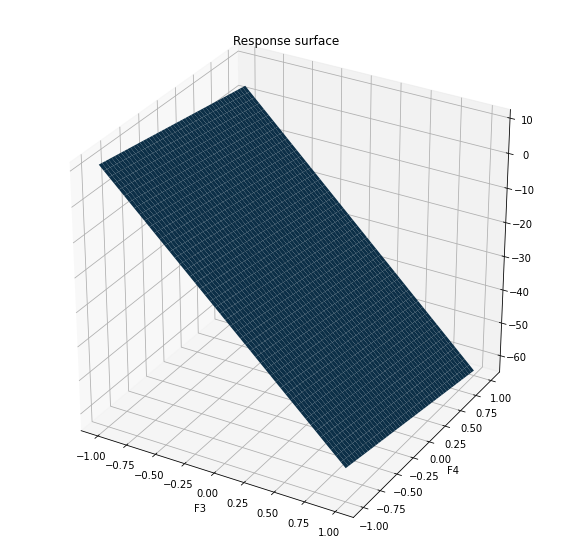

In [ ]:
x = np.linspace(-1,1,50)
y = np.linspace(-1,1,50)
X,Y = np.meshgrid(x,y)
Z = z(e3_bar, e4_bar, e34_bar, R_bar,X,Y)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection ='3d')
ax.plot_surface(X, Y, Z)
plt.xlabel('F3')
plt.ylabel('F4')
plt.title('Response surface')
plt.show()

In [ ]:
print('main effect of F3 on monthly profit averaged over all simuation run',round(e3_bar,2))

main effect of F3 on monthly profit averaged over all simuation run -66.32


In [ ]:
print('main effect of F4 on monthly profit averaged over all simuation run',round(e4_bar,2))

main effect of F4 on monthly profit averaged over all simuation run -8.03


In [ ]:
print('interactive effect of F3 and F4 on monthly profit averaged over all simuation run',round(e34_bar,2))

interactive effect of F3 and F4 on monthly profit averaged over all simuation run -0.35


observation - Response surface is a plane as e34_bar is very small. Also F3 effect on profit is more than F4 effect.

Lets first look at  response for F3 and F4 on cycle service level.



In [ ]:
def csl_performance(factor_level_info,alpha,no_of_replication = 1, 
                length_of_each_run = 120, warm_up = 20,
                S = 50,s = 30, backorder = True ):
  csl_replication_matrix = np.zeros(shape = (4,no_of_replication))

  e3 = []
  e4 = []
  e34 = []
  i = 0
  #for backorder_ in factor_level_info[0,:]:
  for S_ in factor_level_info[0,:]:
    for s_ in factor_level_info[1,:]:
      mean_profit,mean_monthly_cost,csl ,data = simulation(no_of_replication=10,
                                                             length_of_each_run = 120,
                                                             warm_up = 20,
                                                             S = S_, s= s_,
                                                             backorder = backorder)
      csl_replication_matrix[i,:] = csl
      i += 1
  for k in range(np.shape(csl_replication_matrix)[1]):
    e3.append(new_main_effect(list(csl_replication_matrix[:,k]),1))
    e4.append(new_main_effect(list(csl_replication_matrix[:,k]),2))
    e34.append(new_interation_effect(list(csl_replication_matrix[:,k]),1,2))
  R_bar = np.matrix.mean(np.matrix(csl_replication_matrix))
  return e3, e4, e34, R_bar


In [ ]:
def new_calculate_confidence_interval_for_effect(e3,e4,e34):
  print('--------Main_Effect_on_csl--------')

  print('mean of 90%CI for effect of Factor 3 e3 is',calculate_mean_and_half_width(e3,alpha = 0.01,
                                                                                   no_of_replications=len(e3))[0])
  print('half width of 90%CI for effect of Factor 3 e3 is',calculate_mean_and_half_width(e3,alpha = 0.01,
                                                                                   no_of_replications=len(e3))[1])
  print('mean of 90%CI for effect of Factor 4 e4 is',calculate_mean_and_half_width(e4,alpha = 0.01,
                                                                                   no_of_replications=len(e4))[0])
  print('half width of 90%CI for effect of Factor 4 e4 is',calculate_mean_and_half_width(e4,alpha = 0.01,
                                                                                   no_of_replications=len(e4))[1])
  print('--------Interaction_Effect_on_csl----------')

  print('mean of 90%CI for effect of Factor 3and4 e34 is',calculate_mean_and_half_width(e34,alpha = 0.01,
                                                                                   no_of_replications=len(e34))[0])
  print('half width of 90%CI for effect of Factor 3and4 e34 is',calculate_mean_and_half_width(e34,alpha = 0.01,
                                                                                   no_of_replications=len(e34))[1])

In [ ]:
 e3, e4, e34,R_bar = csl_performance(factor_level_info, 
                                        alpha = 0.01, no_of_replication = 10,
                                        length_of_each_run=120, warm_up=20)
new_calculate_confidence_interval_for_effect(e3,e4,e34)

--------Main_Effect_on_csl--------
mean of 90%CI for effect of Factor 3 e3 is 0.22
half width of 90%CI for effect of Factor 3 e3 is 0.04
mean of 90%CI for effect of Factor 4 e4 is 0.02
half width of 90%CI for effect of Factor 4 e4 is 0.05
--------Interaction_Effect_on_csl----------
mean of 90%CI for effect of Factor 3and4 e34 is -0.0
half width of 90%CI for effect of Factor 3and4 e34 is 0.06


Clearly switching F3 from 50 to 100 increases cls by 0.22 on average but F4 has no. effect as the CI contains zero.

So there is a trade off between the mean_monthly_profit and CSL . If I decrease M the there is positive change in mean_monthly_profit and negative change in csl.

So according to $OptionB$ i need to find minimum value of M so that profit is max. and csl >= 0.95


In [ ]:
def run(S,s):
  mean_profit,mean_monthly_cost,csl ,data = simulation(10,120,20,S,s,True)
  
  mean_csl = np.mean(csl)
  #print(mean_csl)
  if mean_csl < 0.95 :
    S = S + 1
    s = s + 5
    run(S,s)
  else:
    print('S is:',S)
    print('s is:',s)
    print('cycle service level:',mean_csl)

In [ ]:
 run(100,40)

S is: 108
s is: 80
cycle service level: 0.953


In [ ]:
mean_profit,mean_monthly_cost,csl ,data = simulation(10, 120, 20, 108, 80, True)

In [ ]:
print('minimum monthly profit for csl >= 95%',np.mean(mean_profit))

minimum monthly profit for csl >= 95% -130.222
